이미지 크기: (512, 512)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


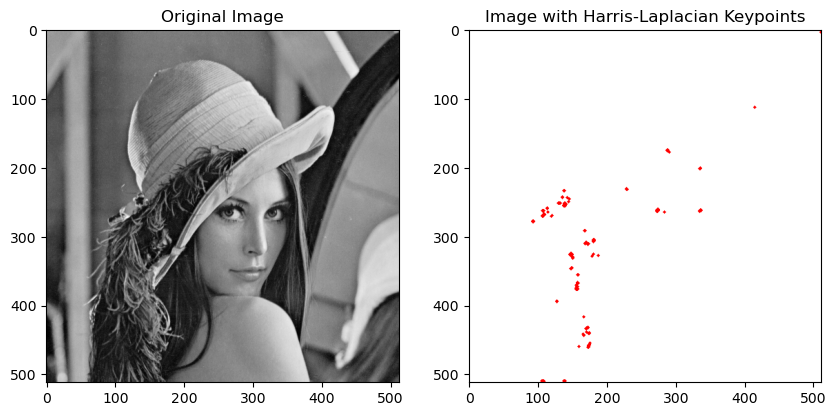

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_laplace  # 스케일 공간 계산을 위해 scipy 사용

# 1. 이미지 로드 (cv2 사용)
def load_image_as_gray(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"이미지를 로드할 수 없습니다: {image_path}")
    return np.array(img, dtype=np.float32)

# 2. Sobel 필터로 기울기 계산
def compute_gradients(image):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)

    h, w = image.shape
    grad_x = np.zeros((h, w))
    grad_y = np.zeros((h, w))

    padded_img = np.pad(image, ((1, 1), (1, 1)), mode='constant')

    for y in range(h):
        for x in range(w):
            grad_x[y, x] = np.sum(padded_img[y:y+3, x:x+3] * sobel_x)
            grad_y[y, x] = np.sum(padded_img[y:y+3, x:x+3] * sobel_y)

    return grad_x, grad_y

# 3. Harris 응답 계산
def harris_response(image, k=0.04, window_size=3):
    h, w = image.shape
    offset = window_size // 2

    grad_x, grad_y = compute_gradients(image)
    Ixx = grad_x ** 2
    Ixy = grad_x * grad_y
    Iyy = grad_y ** 2

    kernel = np.ones((window_size, window_size)) / (window_size ** 2)
    Sxx = np.zeros((h, w))
    Sxy = np.zeros((h, w))
    Syy = np.zeros((h, w))

    padded_Ixx = np.pad(Ixx, ((offset, offset), (offset, offset)), mode='constant')
    padded_Ixy = np.pad(Ixy, ((offset, offset), (offset, offset)), mode='constant')
    padded_Iyy = np.pad(Iyy, ((offset, offset), (offset, offset)), mode='constant')

    for y in range(h):
        for x in range(w):
            Sxx[y, x] = np.sum(padded_Ixx[y:y+window_size, x:x+window_size] * kernel)
            Sxy[y, x] = np.sum(padded_Ixy[y:y+window_size, x:x+window_size] * kernel)
            Syy[y, x] = np.sum(padded_Iyy[y:y+window_size, x:x+window_size] * kernel)

    det_M = Sxx * Syy - Sxy ** 2
    trace_M = Sxx + Syy
    R = det_M - k * (trace_M ** 2)

    R_max = np.max(np.abs(R))
    if R_max != 0:
        R = R / R_max
    return R

# 4. 라플라시안 응답 계산 (스케일 공간)
def compute_laplacian_response(image, sigma):
    # 가우시안 라플라시안(LoG) 계산
    return gaussian_laplace(image, sigma)

# 5. Harris-Laplacian 특징점 검출
def harris_laplacian_detection(image, sigmas, t_harris=0.01, t_laplace=1.4, s=0.7):
    h, w = image.shape
    keypoints = []  # (y, x, sigma) 형식으로 특징점 저장
    F_temp = []  # Harris 응답을 임시 저장

    # Harris 응답 계산 (초기 스케일)
    harris_base = harris_response(image)
    F_temp = [(y, x, 0) for y in range(h) for x in range(w) if harris_base[y, x] > t_harris]

    # 각 스케일에서 반복
    for sigma in sigmas:
        # 스케일된 이미지 생성 (가우시안 블러 적용)
        blurred_img = gaussian_laplace(image, sigma)
        laplace_response = compute_laplacian_response(image, sigma)

        # Harris 응답 계산 (스케일된 이미지에서)
        harris_response_current = harris_response(blurred_img)

        # 새로운 F 계산
        F = []
        for y, x, _ in F_temp:
            if 0 <= y < h and 0 <= x < w:
                if harris_response_current[y, x] > t_harris:
                    # 라플라시안 응답 비교
                    current_laplace = laplace_response[y, x]
                    max_laplace = -float('inf')
                    best_sigma = sigma

                    # 주변 스케일에서 최대 라플라시안 찾기
                    for neighbor_sigma in [sigma * s, sigma / s]:
                        if neighbor_sigma in sigmas:
                            neighbor_laplace = compute_laplacian_response(image, neighbor_sigma)[y, x]
                            if neighbor_laplace > max_laplace:
                                max_laplace = neighbor_laplace
                                best_sigma = neighbor_sigma

                    # 현재 스케일에서 라플라시안이 최대이고, 임계값 이상이면 특징점 추가
                    if abs(current_laplace) > t_laplace and current_laplace == max_laplace:
                        F.append((y, x, sigma))
                    else:
                        F.append((y, x, best_sigma))

        F_temp = F.copy()

    return F_temp

# 6. 코너 위치를 원본 이미지에 오버레이
def overlay_keypoints_on_image(original_img, keypoints, color=(255, 0, 0)):
    original_color = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)
    for y, x, _ in keypoints:
        if 0 <= y < original_color.shape[0] and 0 <= x < original_color.shape[1]:
            cv2.circle(original_color, (x, y), 2, color, -1)  # 빨간색 점
    return original_color

# 7. 결과 시각화
def plot_results(original_img, overlay_img):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img, cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.title("Image with Harris-Laplacian Keypoints")
    plt.imshow(overlay_img)
    plt.show()

# 8. 메인 실행
if __name__ == "__main__":
    image_path = "./image/lena.bmp"  # 실제 이미지 경로로 변경
    gray_image = load_image_as_gray(image_path)
    print(f"이미지 크기: {gray_image.shape}")
    
    # 스케일 공간 정의 (예: 1.0, 1.4, 1.96, ...)
    sigmas = [1.0, 1.4, 1.96, 2.744, 3.8416]  # s=0.7로 증가
    t_harris = 0.01  # Harris 임계값
    t_laplace = 1.4  # 라플라시안 임계값
    s = 0.7  # 스케일 비율

    # Harris-Laplacian 특징점 검출
    keypoints = harris_laplacian_detection(gray_image, sigmas, t_harris, t_laplace, s)
    
    # 코너 오버레이
    overlay_image = overlay_keypoints_on_image(gray_image, keypoints)
    
    # 결과 시각화
    plot_results(gray_image, overlay_image)